In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#importing libraries
import pandas as pd
import sklearn as sk

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt  # Matlab-style plotting

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print("Check for Missing Data in Training Set")
isDataMissing(data)

Check for Missing Data in Training Set


,Total,Percent
price,317017,0.364821
Item Name,7839,0.009021
Date,0,0.000000
datesk,0,0.000000


In [4]:
#load the data into a Pandas dataframe
data = pd.read_excel('Vegetable and Fruits Prices  in India.xlsx')

print("Training Data")
display(data)

#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
data.duplicated().sum()

def isDataMissing(DataToCheck):
#missing data
    total = DataToCheck.isnull().sum().sort_values(ascending=False)
    percent = (DataToCheck.isnull().sum()/DataToCheck.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data.head(20))

Training Data


,datesk,Item Name,Date,price
0,20110101,Kashini greens,2011-01-01 00:00:00,NaN
1,20110101,Pineapple juice,2011-01-01 00:00:00,NaN
2,20110101,Thiland Juice,2011-01-01 00:00:00,NaN
3,20110101,Thiland Jelly,2011-01-01 00:00:00,NaN
4,20110101,Orange juice,2011-01-01 00:00:00,NaN
...,...,...,...,...
868960,20180227,Komark fruit,27/02/2018,28.0
868961,20180227,Dry dates,27/02/2018,20.0
868962,20180227,Tamarind seedless,27/02/2018,230.0
868963,20180227,Dry fruit mixed,27/02/2018,NaN


In [5]:
#Since Datesk is id field remove it
data.drop(columns =['datesk'],inplace=True)
print("Remove rows where item name is blank")
#Remove rows where item name is blank 
data = data[~data['Item Name'].isnull()]
display(data)
#Extract year from date column
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data.drop(columns='Date',inplace=True)

Remove rows where item name is blank


,Item Name,Date,price
0,Kashini greens,2011-01-01 00:00:00,NaN
1,Pineapple juice,2011-01-01 00:00:00,NaN
2,Thiland Juice,2011-01-01 00:00:00,NaN
3,Thiland Jelly,2011-01-01 00:00:00,NaN
4,Orange juice,2011-01-01 00:00:00,NaN
...,...,...,...
868960,Komark fruit,27/02/2018,28.0
868961,Dry dates,27/02/2018,20.0
868962,Tamarind seedless,27/02/2018,230.0
868963,Dry fruit mixed,27/02/2018,NaN


In [6]:
MeanPrices = data.groupby(['Item Name','year']).mean()
print("Mean Prices for all the items on yearwise basis")
display(MeanPrices)

Mean Prices for all the items on yearwise basis


price
Item Name     year           
Amla          2011  35.000000
              2012  50.191919
              2013  47.660131
              2014  55.006689
              2015  68.776316
...                       ...
mango Pickles 2014  60.000000
              2015  60.000000
              2016  60.000000
              2017        NaN
              2018        NaN

[2638 rows x 1 columns]

In [7]:
#Save records where price is null or 0 for the items in null prices dataframe
print("Null Prices Dataset containing null and 0 values for price")
nullPrices = data[(data['price'].isnull()) | (data['price']== 0)]
display(nullPrices)

Null Prices Dataset containing null and 0 values for price


,Item Name,price,year
0,Kashini greens,NaN,2011
1,Pineapple juice,NaN,2011
2,Thiland Juice,NaN,2011
3,Thiland Jelly,NaN,2011
4,Orange juice,NaN,2011
...,...,...,...
868951,Dry apricot,0.0,2018
868954,G.nut oil Rice Bron 1 lt,NaN,2018
868955,Fruit Juice Tailand,NaN,2018
868959,G.oil Net rich 500 ml,NaN,2018


In [8]:
#Remove rows where price is null or price is 0 as we will assign mean values for them later

data = data[~((data['price'].isnull()) | (data['price']== 0))]
print("Removing null and 0 prices from the training dataset for feature engineering")
display(data)

Removing null and 0 prices from the training dataset for feature engineering


,Item Name,price,year
296,Sponge Gourd,32.0,2011
22312,Baby corn cleaned,56.0,2011
22313,Baby corn,14.0,2011
22315,Chilakarive green,22.0,2011
22318,Chakota greens,21.0,2011
...,...,...,...
868958,Cherry fruit,150.0,2018
868960,Komark fruit,28.0,2018
868961,Dry dates,20.0,2018
868962,Tamarind seedless,230.0,2018


In [10]:
print("Assigning Mean Price to training set data where price is 0 or NaN")
nullPrices = pd.merge(nullPrices, MeanPrices, left_on=['Item Name', 'year'], right_on=['Item Name', 'year'])
display(nullPrices.drop(columns=['price_x']))

# Create a DataFrame with the corrected prices
df = pd.DataFrame({
    "Item Name": nullPrices['Item Name'],
    "year": nullPrices['year'],
    "price": nullPrices['price_y']
})

# Combine the original data with the new data using pd.concat
train_data = pd.concat([data, df])

display("Combine dataset after feature engineering")
display(train_data)

Assigning Mean Price to training set data where price is 0 or NaN


,Item Name,year,price_y,price
0,Kashini greens,2011,0.0000,0.0000
1,Kashini greens,2011,0.0000,0.0000
2,Kashini greens,2011,0.0000,0.0000
3,Kashini greens,2011,0.0000,0.0000
4,Kashini greens,2011,0.0000,0.0000
...,...,...,...,...
465471,Straw Berry,2018,46.1875,46.1875
465472,Straw Berry,2018,46.1875,46.1875
465473,Straw Berry,2018,46.1875,46.1875
465474,Straw Berry,2018,46.1875,46.1875


'Combine dataset after feature engineering'

,Item Name,price,year
296,Sponge Gourd,32.0000,2011
22312,Baby corn cleaned,56.0000,2011
22313,Baby corn,14.0000,2011
22315,Chilakarive green,22.0000,2011
22318,Chakota greens,21.0000,2011
...,...,...,...
465471,Straw Berry,46.1875,2018
465472,Straw Berry,46.1875,2018
465473,Straw Berry,46.1875,2018
465474,Straw Berry,46.1875,2018


In [11]:
#price cannot be zero so filter out data where price is around zero
train_data = train_data[(train_data['price']> 1)]
backup = train_data
print("Backup")
display(backup)

Backup


,Item Name,price,year
296,Sponge Gourd,32.0000,2011
22312,Baby corn cleaned,56.0000,2011
22313,Baby corn,14.0000,2011
22315,Chilakarive green,22.0000,2011
22318,Chakota greens,21.0000,2011
...,...,...,...
465471,Straw Berry,46.1875,2018
465472,Straw Berry,46.1875,2018
465473,Straw Berry,46.1875,2018
465474,Straw Berry,46.1875,2018


C:\Users\User\AppData\Local\Temp\ipykernel_25524\2812515789.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['price']);


Skewness: 3.638037769856477


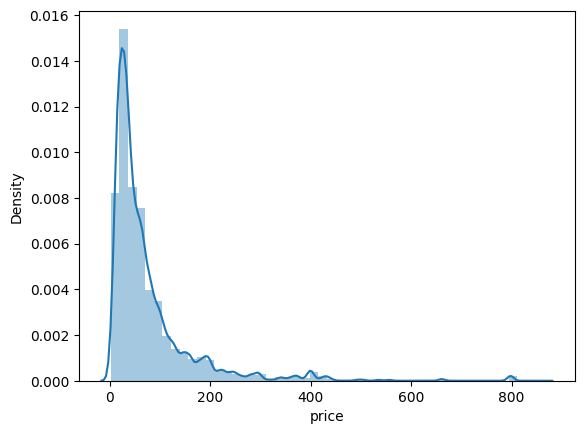

In [12]:
train_data = pd.get_dummies(train_data).reset_index(drop=True)
sns.distplot(train_data['price']);

print("Skewness: " + str(train_data['price'].skew()))

C:\Users\User\AppData\Local\Temp\ipykernel_25524\1143928919.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['price']);


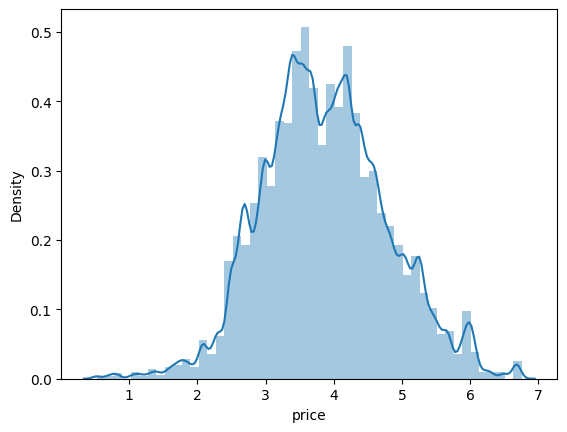

In [13]:
#Histogram is not normally distributed
#sns.distplot(train_data['price']);
#applying log transformation
train_data['price'] = np.log(train_data['price'])
sns.distplot(train_data['price']);

In [14]:
train_output = train_data['price']
#Remove target output column Price from training dataset
train_data.drop(columns='price',inplace=True)
print("Training Dataset")
display(train_data)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_output, test_size = 0.1, random_state = 0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
mean_squared_error(y_pred,y_test)

Training Dataset


,year,Item Name_Amla,Item Name_Anjura/Fig,Item Name_Apple Australia,Item Name_Apple Chaina Delicious,Item Name_Apple Chilli,Item Name_Apple Delicious,Item Name_Apple Economy,Item Name_Apple Fuji chaina,Item Name_Apple Golden delicious,...,Item Name_Times Rose berry,Item Name_Tomoto,Item Name_Washington gala apple,Item Name_Washington red apple,Item Name_Watermellon,Item Name_Watermellon kiran,Item Name_Y.Bananan T.N.,Item Name_Yam/S.Root,Item Name_knol-khol,Item Name_mango Pickles
0,2011,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2011,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2011,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2011,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2011,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676448,2018,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
676449,2018,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
676450,2018,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
676451,2018,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


0.14328132946205036

In [22]:
# Preparing Test Data for 2019 Price predictions
test_data = pd.DataFrame(columns=['year', 'Item Name'])

# Create a list of dictionaries to hold the data
data_list = [{'Item Name': str(item), 'year': 2024} for item in backup['Item Name'].unique()]

# Use pd.concat instead of append
test_data = pd.concat([test_data, pd.DataFrame(data_list)], ignore_index=True)

display(test_data)


,year,Item Name
0,2024,Sponge Gourd
1,2024,Baby corn cleaned
2,2024,Baby corn
3,2024,Chilakarive green
4,2024,Chakota greens
...,...,...
297,2024,Mango Langada
298,2024,Beans Ring
299,2024,Cherry fruit
300,2024,Chillies Bajji yagani


In [23]:
test_data_one_hot = pd.get_dummies(test_data).reset_index(drop=True)

test_data_one_hot.rename(columns ={'year_2024':'year'},inplace=True)
test_data_one_hot['year'] = 2024

print("Testing Data")
display(test_data_one_hot)

Testing Data


,year,Item Name_Amla,Item Name_Anjura/Fig,Item Name_Apple Australia,Item Name_Apple Chaina Delicious,Item Name_Apple Chilli,Item Name_Apple Delicious,Item Name_Apple Economy,Item Name_Apple Fuji chaina,Item Name_Apple Golden delicious,...,Item Name_Times Rose berry,Item Name_Tomoto,Item Name_Washington gala apple,Item Name_Washington red apple,Item Name_Watermellon,Item Name_Watermellon kiran,Item Name_Y.Bananan T.N.,Item Name_Yam/S.Root,Item Name_knol-khol,Item Name_mango Pickles
0,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
300,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
regressor.fit(train_data, train_output)

predictions = regressor.predict(test_data_one_hot)
#print(predictions)

preds = pd.DataFrame()
#convert the logarithmic values to normal form
preds['price'] =np.exp(predictions)
preds['Item Name'] = test_data['Item Name']
preds['year'] = test_data['year']
print("Average price predictions for 2024 year ")
display(preds)

Average price predictions for 2024 year 


,price,Item Name,year
0,64.385948,Sponge Gourd,2024
1,190.552548,Baby corn cleaned,2024
2,42.043265,Baby corn,2024
3,43.190367,Chilakarive green,2024
4,64.195420,Chakota greens,2024
...,...,...,...
297,72.725184,Mango Langada,2024
298,29.734000,Beans Ring,2024
299,139.588944,Cherry fruit,2024
300,64.581045,Chillies Bajji yagani,2024


In [25]:
result_df = preds[['Item Name','price']]

In [26]:
result_df.head()

,Item Name,price
0,Sponge Gourd,64.385948
1,Baby corn cleaned,190.552548
2,Baby corn,42.043265
3,Chilakarive green,43.190367
4,Chakota greens,64.195420


In [27]:
result_df.to_csv('Predict_vegetable_2024_price.csv')